In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
#import folium

from numpy import log, log1p
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy import stats

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder

%matplotlib inline
style.use('fivethirtyeight')
#style.use('dark_background')
#sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('kc_house_data.csv')

Exploratory Data Analysis

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.drop(['id', 'date', 'view', 'yr_renovated', 'lat', 'long'], axis=1, inplace=True)

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,98074,1800,7503


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  int64  
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 2.5 MB


In [8]:
df.isnull().values.any()

False

In [9]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,3.409825,7.657915,1788.596842,291.725008,1970.999676,98077.951845,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.650546,1.173200,827.759761,442.667800,29.375234,53.513072,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,98001.000000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,98118.000000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,6210.000000,871200.000000


In [10]:
print('Number of unique zipcodes in King County:', len(df['zipcode'].unique()))

Number of unique zipcodes in King County: 70


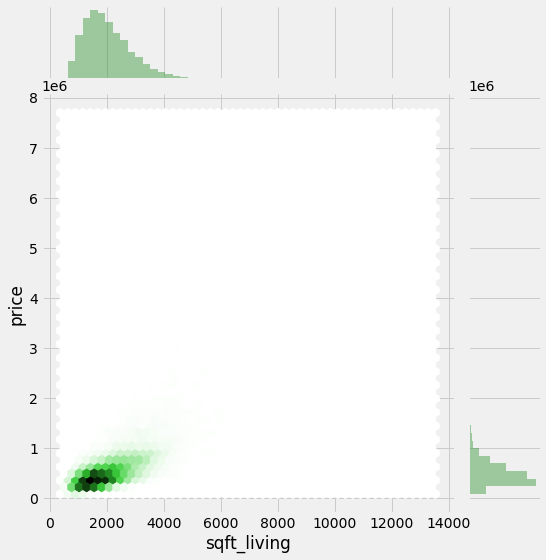

In [11]:
#sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})

sns.jointplot(x='sqft_living', y='price', data=df, color='forestgreen', height=8, kind='hex')

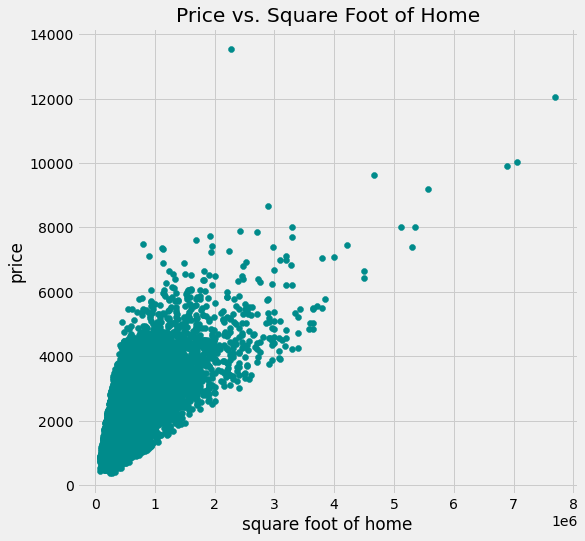

In [12]:
fig = plt.figure(figsize=(8,8))
plt.scatter(df['price'], df['sqft_living'], color='darkcyan')
plt.title('Price vs. Square Foot of Home')
plt.xlabel('square foot of home')
plt.ylabel('price')
plt.show()

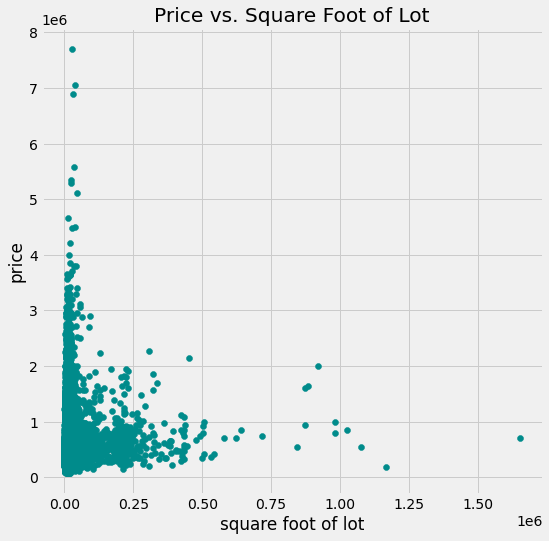

In [13]:
fig = plt.figure(figsize=(8,8))
plt.scatter(df['sqft_lot'], df['price'], color='darkcyan')
plt.title('Price vs. Square Foot of Lot')
plt.xlabel('square foot of lot')
plt.ylabel('price')
plt.show()

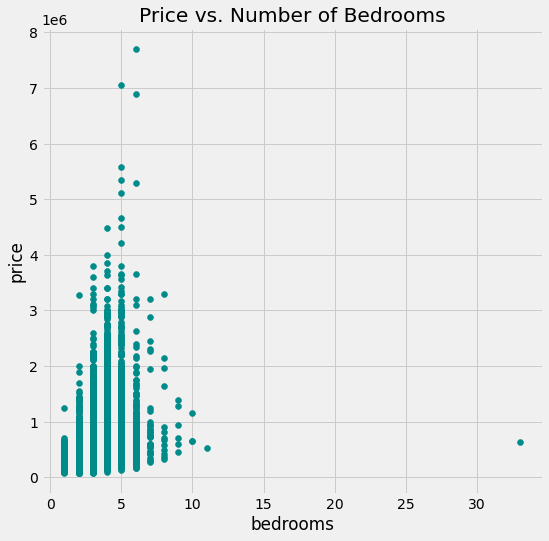

In [14]:
fig = plt.figure(figsize=(8,8))
plt.scatter(df['bedrooms'], df['price'], color='darkcyan')
plt.title('Price vs. Number of Bedrooms')
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.show()

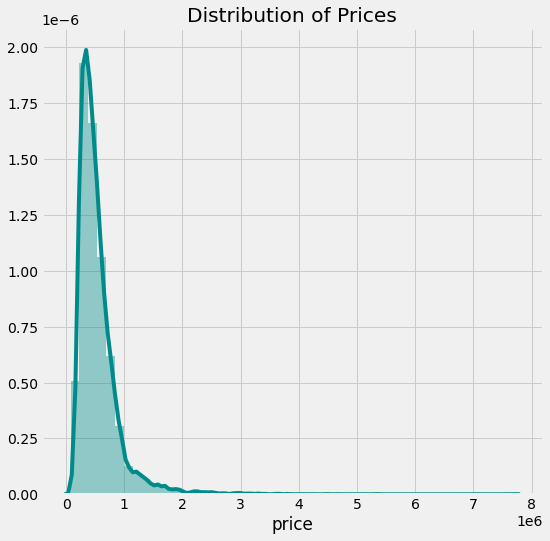

In [15]:
fig = plt.figure(figsize=(8,8))
sns.distplot(df['price'], color='darkcyan')
plt.title('Distribution of Prices')
plt.xlabel('price')
plt.show()

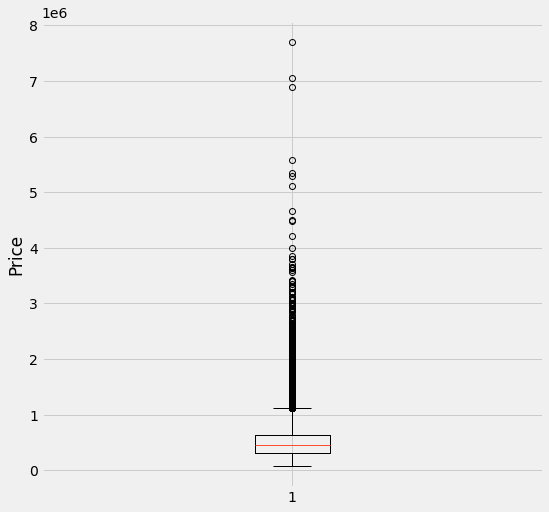

In [16]:
fig = plt.figure(figsize=(8,8))
#boxprops = dict(color='yellow', linewidth=2)
#medianprops = dict(color='yellow', linewidth=2)
#whiskerprops = dict(color='yellow', linewidth=2)
#capprops = dict(color='yellow', linewidth=2)
plt.boxplot(df['price'])
plt.ylabel('Price')
#plt.yscale('log')
plt.show()

In [17]:
# removing outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df.reset_index(drop=True, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20098 entries, 0 to 20097
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20098 non-null  float64
 1   bedrooms       20098 non-null  int64  
 2   bathrooms      20098 non-null  float64
 3   sqft_living    20098 non-null  int64  
 4   sqft_lot       20098 non-null  int64  
 5   floors         20098 non-null  float64
 6   waterfront     20098 non-null  int64  
 7   condition      20098 non-null  int64  
 8   grade          20098 non-null  int64  
 9   sqft_above     20098 non-null  int64  
 10  sqft_basement  20098 non-null  int64  
 11  yr_built       20098 non-null  int64  
 12  zipcode        20098 non-null  int64  
 13  sqft_living15  20098 non-null  int64  
 14  sqft_lot15     20098 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 2.3 MB


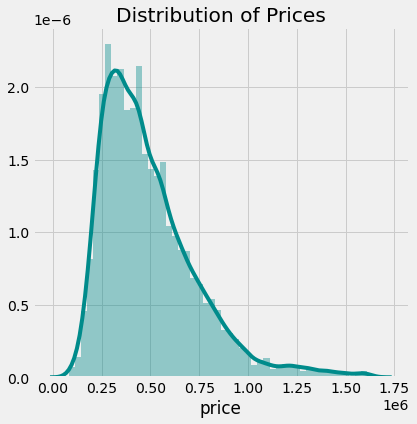

In [19]:
fig = plt.figure(figsize=(6,6))
sns.distplot(df['price'], color='darkcyan')
plt.title('Distribution of Prices')
plt.xlabel('price')
plt.show()

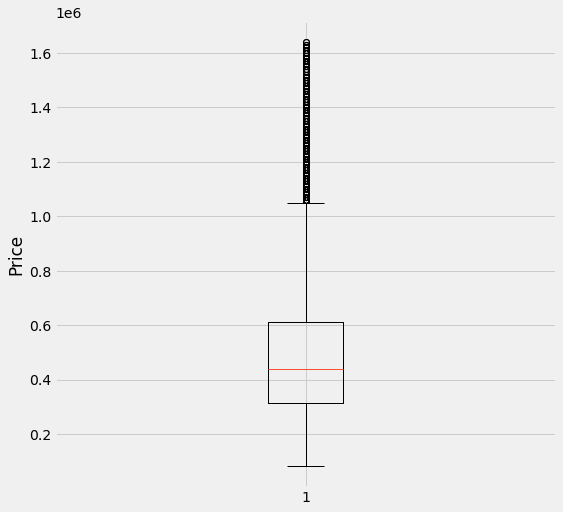

In [20]:
fig = plt.figure(figsize=(8,8))
#boxprops = dict(color='yellow', linewidth=2)
#medianprops = dict(color='yellow', linewidth=2)
#whiskerprops = dict(color='yellow', linewidth=2)
#capprops = dict(color='yellow', linewidth=2)
#plt.boxplot(df['price'], boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.boxplot(df['price'])
plt.ylabel('Price')
plt.show()

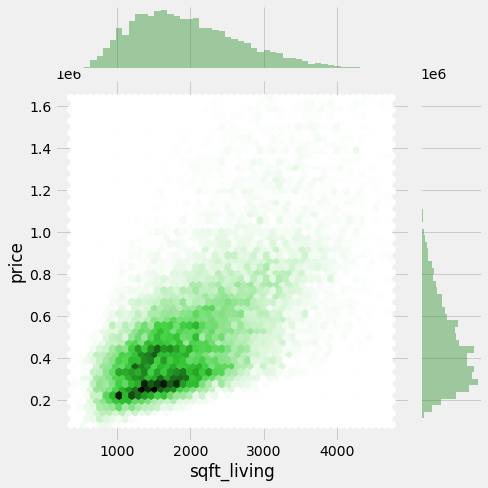

In [21]:
sns.jointplot(x='sqft_living', y='price', data=df, color='forestgreen', height=7, kind='hex')

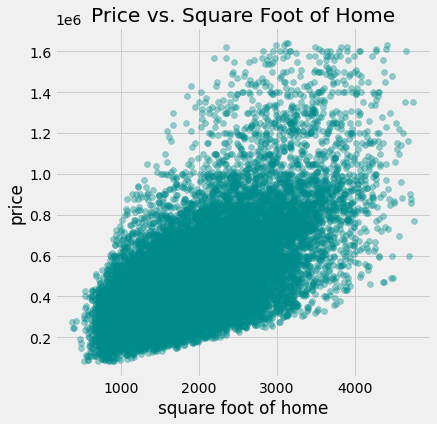

In [22]:
fig = plt.figure(figsize=(6,6))
plt.scatter(df['sqft_living'], df['price'], color='darkcyan', alpha=0.4)
plt.title('Price vs. Square Foot of Home')
plt.xlabel('square foot of home')
plt.ylabel('price')
plt.show()

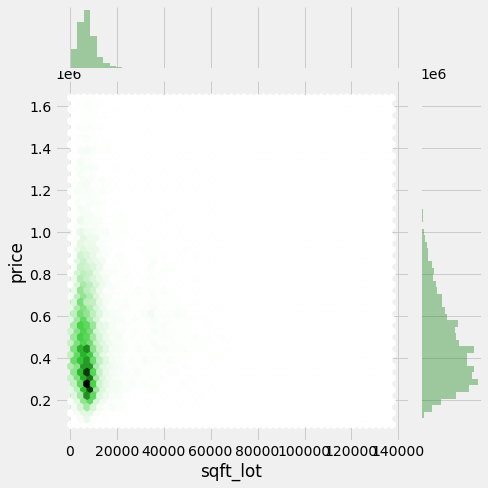

In [23]:
sns.jointplot(x='sqft_lot', y='price', data=df, color='forestgreen', height=7, kind='hex')

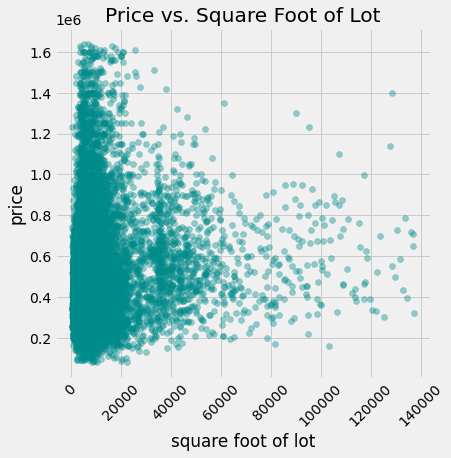

In [24]:
fig = plt.figure(figsize=(6,6))
plt.scatter(df['sqft_lot'], df['price'], color='darkcyan', alpha=0.4)
plt.title('Price vs. Square Foot of Lot')
plt.xlabel('square foot of lot')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

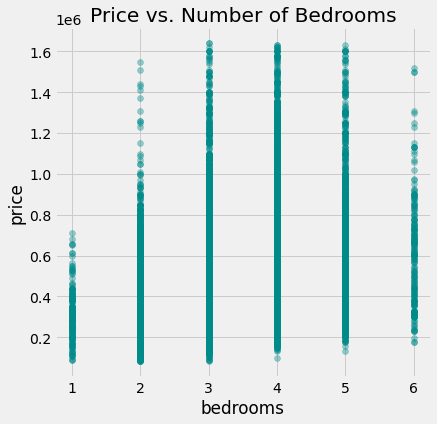

In [25]:
fig = plt.figure(figsize=(6,6))
plt.scatter(df['bedrooms'], df['price'], color='darkcyan', alpha=0.4)
plt.title('Price vs. Number of Bedrooms')
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.show()

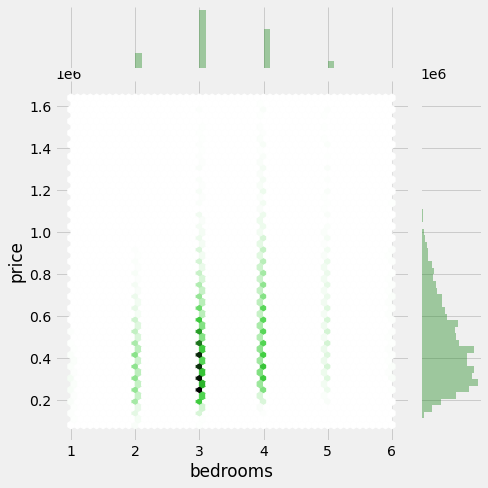

In [26]:
sns.jointplot(x='bedrooms', y='price', data=df, color='forestgreen', height=7, kind='hex')

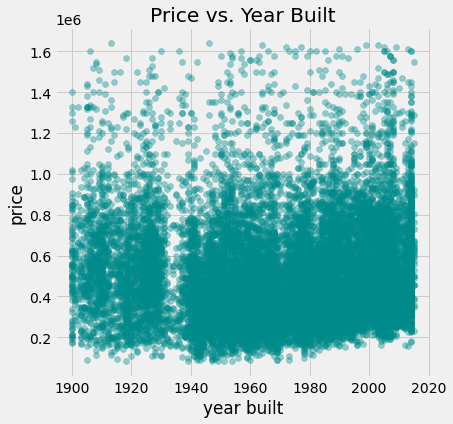

In [27]:
fig = plt.figure(figsize=(6,6))
plt.scatter(df['yr_built'], df['price'], color='darkcyan', alpha=0.4)
plt.title('Price vs. Year Built')
plt.xlabel('year built')
plt.ylabel('price')
plt.show()

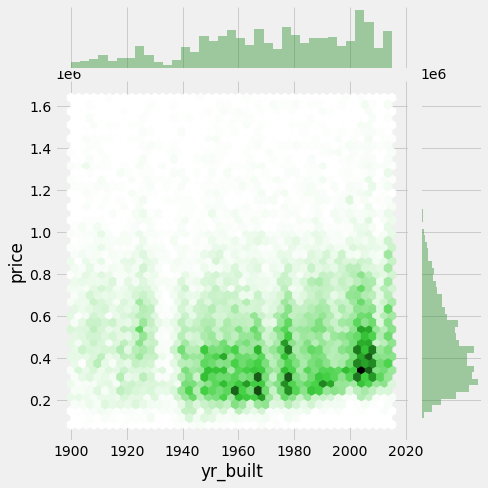

In [28]:
sns.jointplot(x='yr_built', y='price', data=df, color='forestgreen', height=7, kind='hex')

In [29]:
df['price_log'] = np.log1p(df['price'])

In [30]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price_log
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,98178,1340,5650,12.309987
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,98125,1690,7639,13.195616
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,98028,2720,8062,12.100718
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,98136,1360,5000,13.311331
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,98074,1800,7503,13.142168


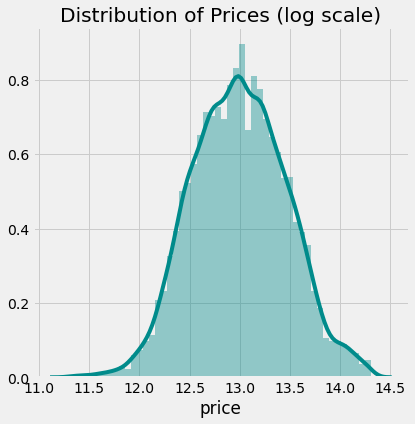

In [31]:
fig = plt.figure(figsize=(6,6))
sns.distplot(df['price_log'], color='darkcyan')
plt.title('Distribution of Prices (log scale)')
plt.xlabel('price')
plt.show()

In [32]:
# boxcox transformation

from scipy.stats import boxcox

bc_result = boxcox(df['price'])
boxcox_price = bc_result[0]
lam = bc_result[1]

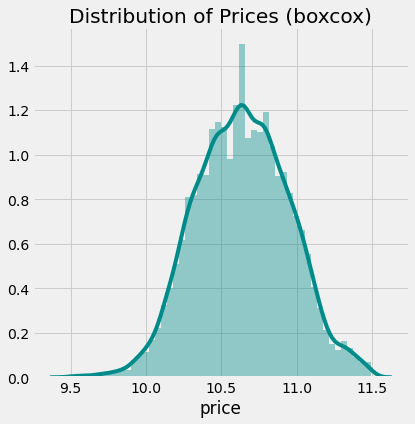

In [33]:
fig = plt.figure(figsize=(6,6))
sns.distplot(boxcox_price, color='darkcyan')
plt.title('Distribution of Prices (boxcox)')
plt.xlabel('price')
plt.show()

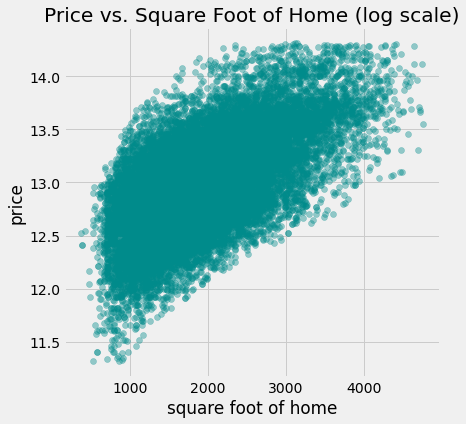

In [34]:
fig = plt.figure(figsize=(6,6))
plt.scatter(df['sqft_living'], df['price_log'], color='darkcyan', alpha=0.4)
plt.title('Price vs. Square Foot of Home (log scale)')
plt.xlabel('square foot of home')
plt.ylabel('price')
plt.show()

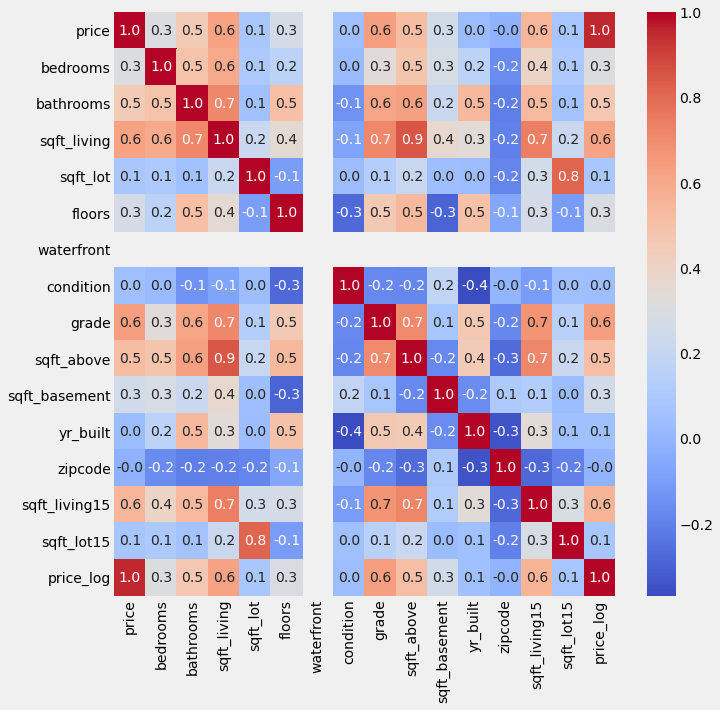

In [35]:
# create correlation matrix

corr_matrix = df.corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.show()

In [36]:
# finding p value using t test

price = np.array(df['price'])
price_mean = np.mean(price)
tset, pval = stats.ttest_1samp(price, 500000)

print('Mean of prices:', price_mean)
print('tset:', tset)
print('p value:', pval)

Mean of prices: 492251.99318340136
tset: -4.519847207864474
p value: 6.223723105654651e-06


Machine Learning - Linear Regression

In [37]:
def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [38]:
# create dummy variables for zipcodes

dummy = pd.get_dummies(df['zipcode'].astype(str))
df_dummies = pd.concat([df, dummy], axis=1)

In [39]:
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X = df.drop('price', axis=1)
Y = df['price']

In [41]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price_log
0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,98178,1340,5650,12.309987
1,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,98125,1690,7639,13.195616
2,2,1.00,770,10000,1.0,0,3,6,770,0,1933,98028,2720,8062,12.100718
3,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,98136,1360,5000,13.311331
4,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,98074,1800,7503,13.142168


In [42]:
Y.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [44]:
kf = KFold(shuffle=True, random_state=72018, n_splits=10)
skf = StratifiedKFold(shuffle=True, n_splits=10)

In [45]:
model_list =[]
r2_list = []
rmse_list = []
kf_list = []
skf_list = []

In [46]:
# linear regression

pf = PolynomialFeatures(degree=2)
s = StandardScaler()
lr = LinearRegression()

estimator_lr = Pipeline([('polynomial features', pf), ('scaler', s), ('regression', lr)])


In [47]:
estimator_lr.fit(X_train, y_train)
y_predict_lr = estimator_lr.predict(X_test)
y_predict_lr_kf = cross_val_predict(estimator_lr, X, Y, cv=kf)
y_predict_lr_skf = cross_val_predict(estimator_lr, X, Y, cv=skf)

In [48]:
lr_r2 = r2_score(y_predict_lr, y_test)
lr_rmse = rmse(y_predict_lr, y_test)
print('R score for linear regression:', lr_r2) 
print('RMSE for linear regression:', lr_rmse)

R score for linear regression: 0.9955718828692338
RMSE for linear regression: 15960.768027637087


In [49]:
cvs_lr_kf = cross_val_score(estimator_lr, X, Y, cv=kf)
cvs_lr_skf = cross_val_score(estimator_lr, X, Y, cv=skf)
print('Average K Fold Cross Validation Score for linear regression:', np.mean(cvs_lr_kf))
print('Average Stratified K Fold Cross Validation Score for linear regression:', np.mean(cvs_lr_skf))

Average K Fold Cross Validation Score for linear regression: 0.9954406927105717
Average Stratified K Fold Cross Validation Score for linear regression: 0.9954392833435769


In [50]:
model_list.append('Linear Regression')
r2_list.append(lr_r2)
rmse_list.append(lr_rmse)
kf_list.append(np.mean(cvs_lr_kf))
skf_list.append(np.mean(cvs_lr_skf))

In [51]:
# ridge regression

pf = PolynomialFeatures(degree=2)
s = StandardScaler()
ridge = Ridge(alpha=0.001)

estimator_ridge = Pipeline([('polynomial_features', pf), ('scaler', s), ('ridge', ridge)])

In [52]:
estimator_ridge.fit(X_train, y_train)
y_predict_ridge = estimator_ridge.predict(X_test)
y_predict_ridge_kf = cross_val_predict(estimator_ridge, X, Y, cv=kf)
y_predict_ridge_skf = cross_val_predict(estimator_ridge, X, Y, cv=skf)

In [53]:
ridge_r2 = r2_score(y_predict_ridge, y_test)
ridge_rmse = rmse(y_predict_ridge, y_test)

print('R score for ridge:', ridge_r2)
print('RMSE for ridge:', ridge_rmse)

R score for ridge: 0.9955710990893769
RMSE for ridge: 15961.331626488205


In [54]:
cvs_ridge_kf = cross_val_score(estimator_ridge, X, Y, cv=kf)
cvs_ridge_skf = cross_val_score(estimator_ridge, X, Y, cv=skf)
print('Average K Fold Cross Validation Score for ridge:', np.mean(cvs_ridge_kf))
print('Average Stratified K Fold Cross Validation Score for ridge:', np.mean(cvs_ridge_skf))

Average K Fold Cross Validation Score for ridge: 0.9954408720431877
Average Stratified K Fold Cross Validation Score for ridge: 0.9954499962864716


In [55]:
alphas1 = np.array([1e-11, 1e-8, 1e-5, 0.001, 0.1])
params_ridge = {'ridge__alpha': alphas1}
grid_ridge = GridSearchCV(estimator_ridge, params_ridge, cv=kf)
grid_ridge.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=10, random_state=72018, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': array([1.e-11, 1.e-08, 1.e-05, 1.e-03, 1.e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
print('Ridge')
print('Best score:', grid_ridge.best_score_)
print('Best parameters:', grid_ridge.best_params_)
print('Best estimator:', grid_ridge.best_estimator_)

Ridge
Best score: 0.9954408670472136
Best parameters: {'ridge__alpha': 0.001}
Best estimator: Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


In [57]:
ridgeCV = RidgeCV(alphas=alphas1, cv=kf)
ridgeCV.fit(X, Y)

RidgeCV(alphas=array([1.e-11, 1.e-08, 1.e-05, 1.e-03, 1.e-01]),
    cv=KFold(n_splits=10, random_state=72018, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [58]:
print('Ridge CV')
print('Best alpha:', ridgeCV.alpha_)

Ridge CV
Best alpha: 0.1


In [59]:
model_list.append('Ridge')
r2_list.append(ridge_r2)
rmse_list.append(ridge_rmse)
kf_list.append(np.mean(cvs_ridge_kf))
skf_list.append(np.mean(cvs_ridge_skf))

In [60]:
# lasso regression

pf = PolynomialFeatures(degree=2)
s = StandardScaler()
lasso = Lasso(alpha=1e-11)

estimator_lasso = Pipeline([('polynomial features', pf), ('scaler', s), ('lasso', lasso)])

In [61]:
estimator_lasso.fit(X_train, y_train)
y_predict_lasso = estimator_lasso.predict(X_test)
y_predict_lasso_kf = cross_val_predict(estimator_lasso, X, Y, cv=kf)
y_predict_lasso_skf = cross_val_predict(estimator_lasso, X, Y, cv=skf)

In [62]:
lasso_r2 = r2_score(y_predict_lasso, y_test)
lasso_rmse = rmse(y_predict_lasso, y_test)
print('R score for lasso:', lasso_r2)
print('RMSE for lasso:', lasso_rmse)

R score for lasso: 0.9800829098786604
RMSE for lasso: 33546.85089996915


In [63]:
cvs_lasso_kf = cross_val_score(estimator_lasso, X, Y, cv=kf)
cvs_lasso_skf = cross_val_score(estimator_lasso, X, Y, cv=skf)
print('Average K Fold Cross Validation Score for lasso:', np.mean(cvs_lasso_kf))
print('Average Stratified K Fold Cross Validation Score for lasso:', np.mean(cvs_lasso_skf))

Average K Fold Cross Validation Score for lasso: 0.9803420084003571
Average Stratified K Fold Cross Validation Score for lasso: 0.980328007984015


In [64]:
alphas2 = np.array([1e-11, 1e-8, 1e-5, 0.001, 0.1])
params_lasso = {'lasso__alpha': alphas2}
grid_lasso = GridSearchCV(estimator_lasso, params_lasso, cv=kf)
grid_lasso.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=72018, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomial features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1e-11, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.e-11, 1.e-08, 1.e-05, 1.e-03, 1.e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
print('LASSO')
print('Best score:', grid_lasso.best_score_)
print('Best parameters:', grid_lasso.best_params_)
print('Best estimator:', grid_lasso.best_estimator_)

LASSO
Best score: 0.9803418869069535
Best parameters: {'lasso__alpha': 1e-11}
Best estimator: Pipeline(memory=None,
     steps=[('polynomial features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1e-11, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])


In [66]:
alphas2 = np.array([1e-11, 1e-8, 1e-5, 0.001, 0.1])
lassoCV = LassoCV(alphas=alphas2, max_iter=5e4, cv=3)
lassoCV.fit(X_train, y_train)

LassoCV(alphas=array([1.e-11, 1.e-08, 1.e-05, 1.e-03, 1.e-01]), copy_X=True,
    cv=3, eps=0.001, fit_intercept=True, max_iter=50000.0, n_alphas=100,
    n_jobs=None, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [67]:
print('LASSO CV')
print('Best alpha:', lassoCV.alpha_)

LASSO CV
Best alpha: 1e-11


In [68]:
model_list.append('LASSO')
r2_list.append(lasso_r2)
rmse_list.append(lasso_rmse)
kf_list.append(np.mean(cvs_lasso_kf))
skf_list.append(np.mean(cvs_lasso_skf))

In [69]:
# Elastic Net regression

pf = PolynomialFeatures(degree=2)
s = StandardScaler()
en = ElasticNet(alpha=1e-11, l1_ratio=0.9)

estimator_en = Pipeline([('polynomial features', pf), ('scaler', s), ('en', en)])

In [70]:
estimator_en.fit(X_train, y_train)
y_predict_en = estimator_en.predict(X_test)
y_predict_en_kf = cross_val_predict(estimator_en, X, Y, cv=kf)
y_predict_en_skf = cross_val_predict(estimator_en, X, Y, cv=skf)

In [71]:
en_r2 = r2_score(y_predict_en, y_test)
en_rmse = rmse(y_predict_en, y_test)

print('R score for elastic net:', en_r2)
print('RMSE for elastic net:', en_rmse)

R score for elastic net: 0.980082909877535
RMSE for elastic net: 33546.85090039748


In [72]:
cvs_en_kf = cross_val_score(estimator_en, X, Y, cv=kf)
cvs_en_skf = cross_val_score(estimator_en, X, Y, cv=skf)
print('Average K Fold Cross Validation Score for Elastic Net:', np.mean(cvs_en_kf))
print('Average Stratified K Fold Cross Validation Score for Elastic Net:', np.mean(cvs_en_skf))

Average K Fold Cross Validation Score for Elastic Net: 0.9803420083995908
Average Stratified K Fold Cross Validation Score for Elastic Net: 0.9803214529205782


In [73]:
l1_ratios = np.linspace(0.1, 0.9, 9)
alphas3 = np.array([1e-11, 1e-8, 1e-5, 0.001, 0.1])
params_en = {'en__alpha': alphas3, 'en__l1_ratio': l1_ratios}
grid_en = GridSearchCV(estimator_en, params_en, cv=kf)
grid_en.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=72018, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomial features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('en', ElasticNet(alpha=1e-11, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'en__alpha': array([1.e-11, 1.e-08, 1.e-05, 1.e-03, 1.e-01]), 'en__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
print('Elastic Net')
print('Best score:', grid_en.best_score_)
print('Best parameters:', grid_en.best_params_)
print('Best estimator:', grid_en.best_estimator_)

Elastic Net
Best score: 0.9803418869061871
Best parameters: {'en__alpha': 1e-11, 'en__l1_ratio': 0.9}
Best estimator: Pipeline(memory=None,
     steps=[('polynomial features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('en', ElasticNet(alpha=1e-11, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])


In [75]:
l1_ratios = np.linspace(0.1, 0.9, 9)
alphas3 = np.array([1e-11, 1e-8, 1e-5, 0.001, 0.1])

enCV = ElasticNetCV(alphas=alphas3, l1_ratio=l1_ratios, max_iter=1e4)
enCV.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.e-11, 1.e-08, 1.e-05, 1.e-03, 1.e-01]),
       copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
       l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
       max_iter=10000.0, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [76]:
print('Elastic Net CV')
print('Best alpha:', enCV.alpha_)
print('Best L1 ratio:', enCV.l1_ratio_)

Elastic Net CV
Best alpha: 1e-11
Best L1 ratio: 0.9


In [77]:
model_list.append('Elastic Net')
r2_list.append(en_r2)
rmse_list.append(en_rmse)
kf_list.append(np.mean(cvs_en_kf))
skf_list.append(np.mean(cvs_en_skf))

In [78]:
data = {'model': model_list, 'r2': r2_list, 'rmse': rmse_list, 'kf': kf_list, 'stratified kf': skf_list}

scores = pd.DataFrame(data, columns = ['model', 'r2', 'rmse', 'kf', 'stratified kf'])
scores_styled = scores.style.background_gradient()

In [79]:
scores.head()

,model,r2,rmse,kf,stratified kf
0,Linear Regression,0.995572,15960.768028,0.995441,0.995439
1,Ridge,0.995571,15961.331626,0.995441,0.995450
2,LASSO,0.980083,33546.850900,0.980342,0.980328
3,Elastic Net,0.980083,33546.850900,0.980342,0.980321


In [80]:
scores_styled

,model,r2,rmse,kf,stratified kf
0,Linear Regression,0.995572,15960.768028,0.995441,0.995439
1,Ridge,0.995571,15961.331626,0.995441,0.995450
2,LASSO,0.980083,33546.850900,0.980342,0.980328
3,Elastic Net,0.980083,33546.850900,0.980342,0.980321


In [81]:
import dataframe_image as dfi

dfi.export(scores, 'scores.png')

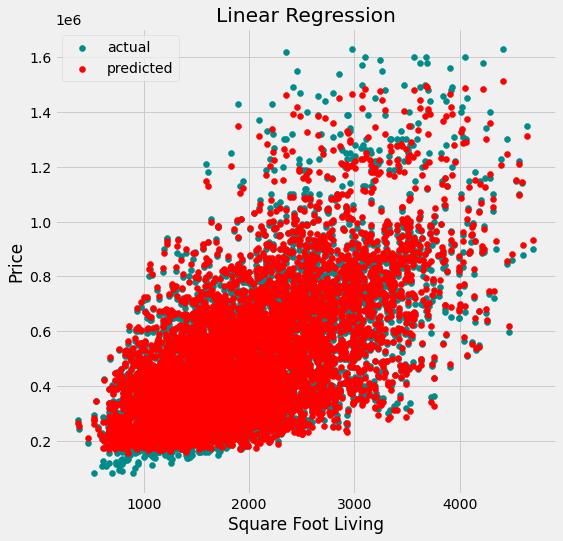

In [82]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_lr, color='red', label='predicted')
plt.title('Linear Regression')
plt.xlabel('Square Foot Living')
plt.ylabel('Price')
plt.legend()
plt.show()

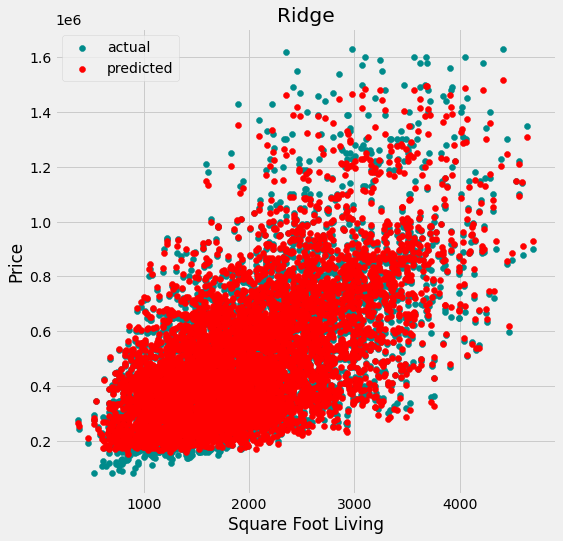

In [83]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_ridge, color='red', label='predicted')
plt.title('Ridge')
plt.xlabel('Square Foot Living')
plt.ylabel('Price')
plt.legend()
plt.show()

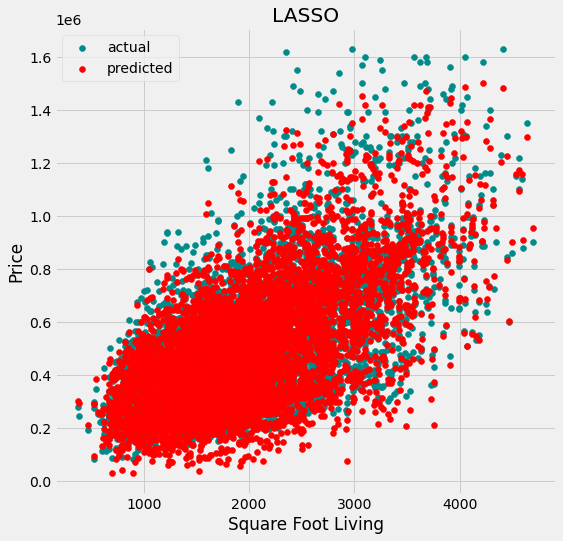

In [84]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_lasso, color='red', label='predicted')
plt.title('LASSO')
plt.xlabel('Square Foot Living')
plt.ylabel('Price')
plt.legend()
plt.show()

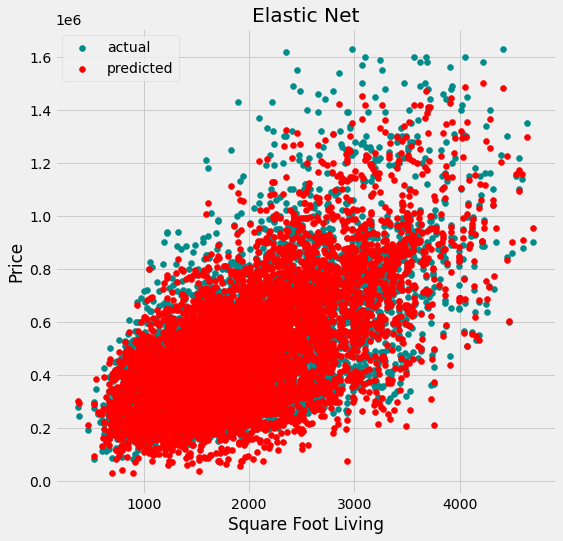

In [85]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_en, color='red', label='predicted')
plt.title('Elastic Net')
plt.xlabel('Square Foot Living')
plt.ylabel('Price')
plt.legend()
plt.show()

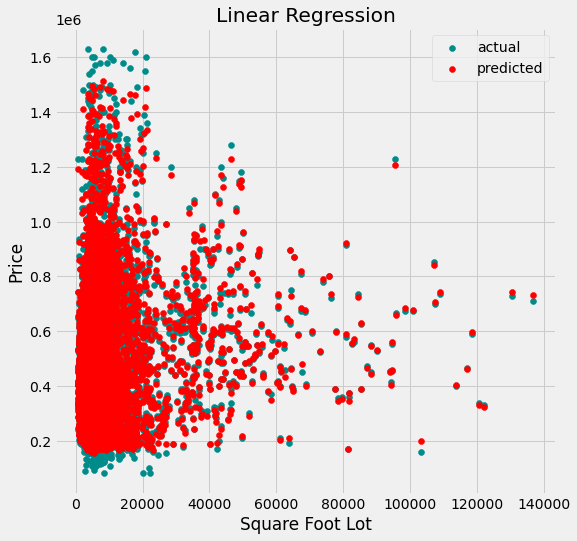

In [86]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_lr, color='red', label='predicted')
plt.title('Linear Regression')
plt.xlabel('Square Foot Lot')
plt.ylabel('Price')
plt.legend()
plt.show()

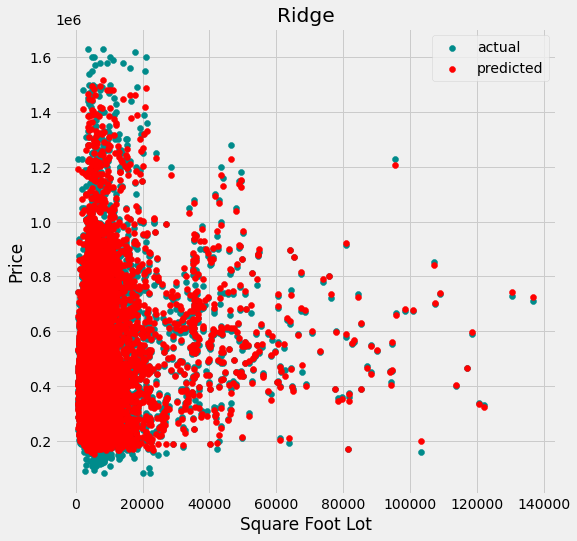

In [87]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_ridge, color='red', label='predicted')
plt.title('Ridge')
plt.xlabel('Square Foot Lot')
plt.ylabel('Price')
plt.legend()
plt.show()

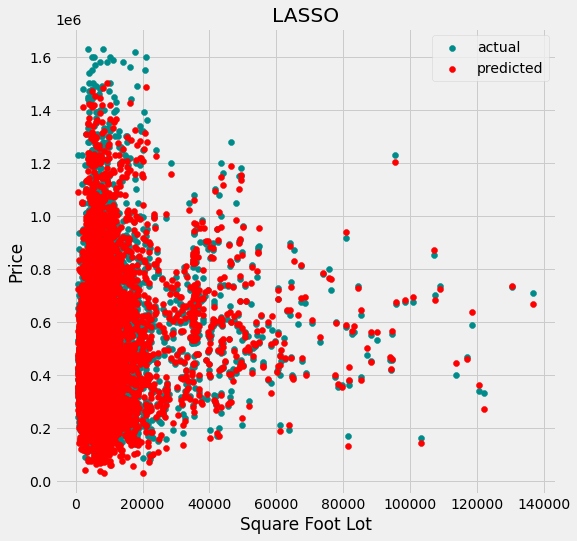

In [88]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_lasso, color='red', label='predicted')
plt.title('LASSO')
plt.xlabel('Square Foot Lot')
plt.ylabel('Price')
plt.legend()
plt.show()

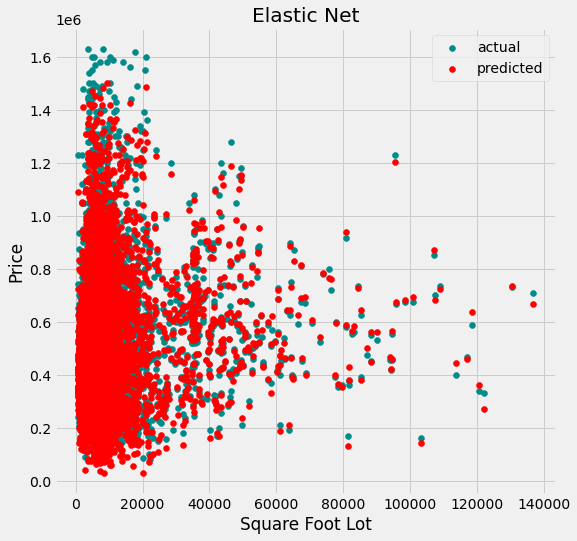

In [89]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_en, color='red', label='predicted')
plt.title('Elastic Net')
plt.xlabel('Square Foot Lot')
plt.ylabel('Price')
plt.legend()
plt.show()

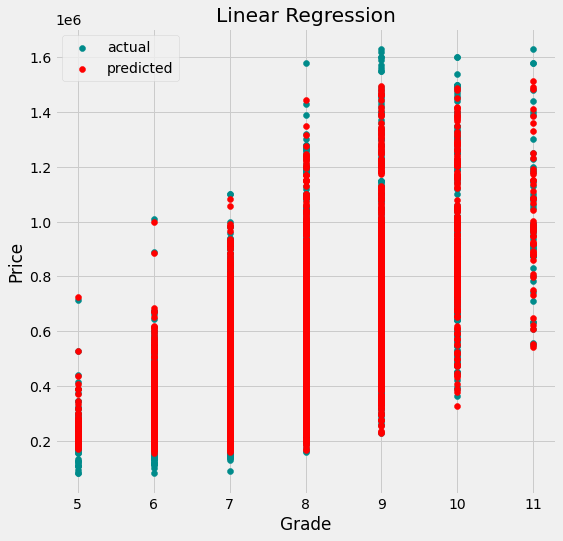

In [90]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_lr, color='red', label='predicted')
plt.title('Linear Regression')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.legend()
plt.show()

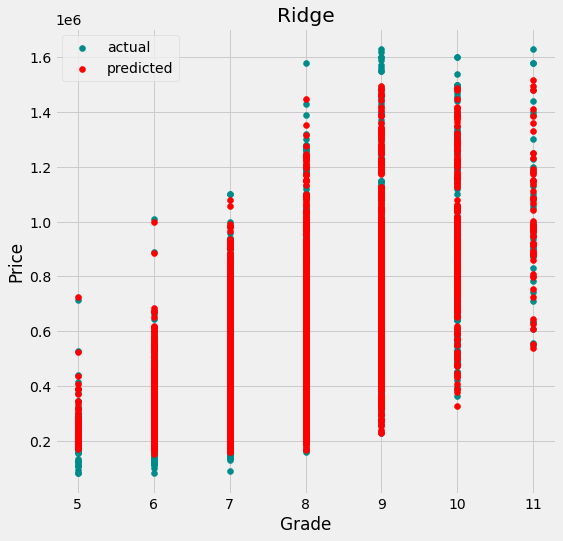

In [91]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_ridge, color='red', label='predicted')
plt.title('Ridge')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.legend()
plt.show()

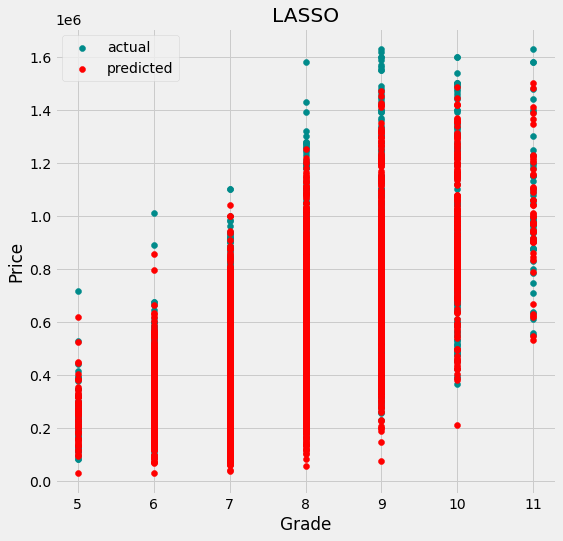

In [92]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_lasso, color='red', label='predicted')
plt.title('LASSO')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.legend()
plt.show()

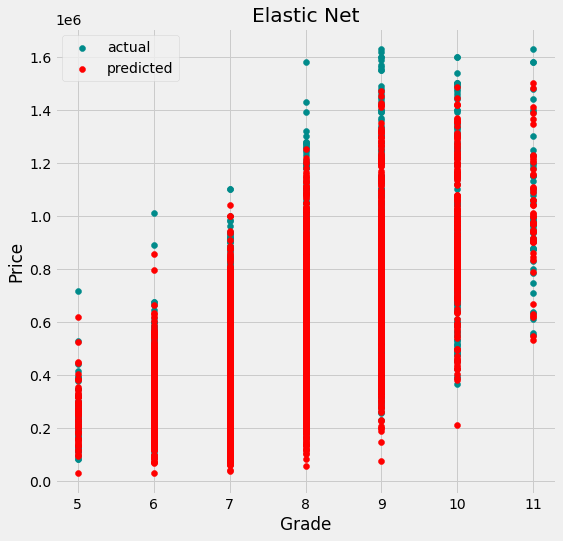

In [93]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_en, color='red', label='predicted')
plt.title('Elastic Net')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.legend()
plt.show()

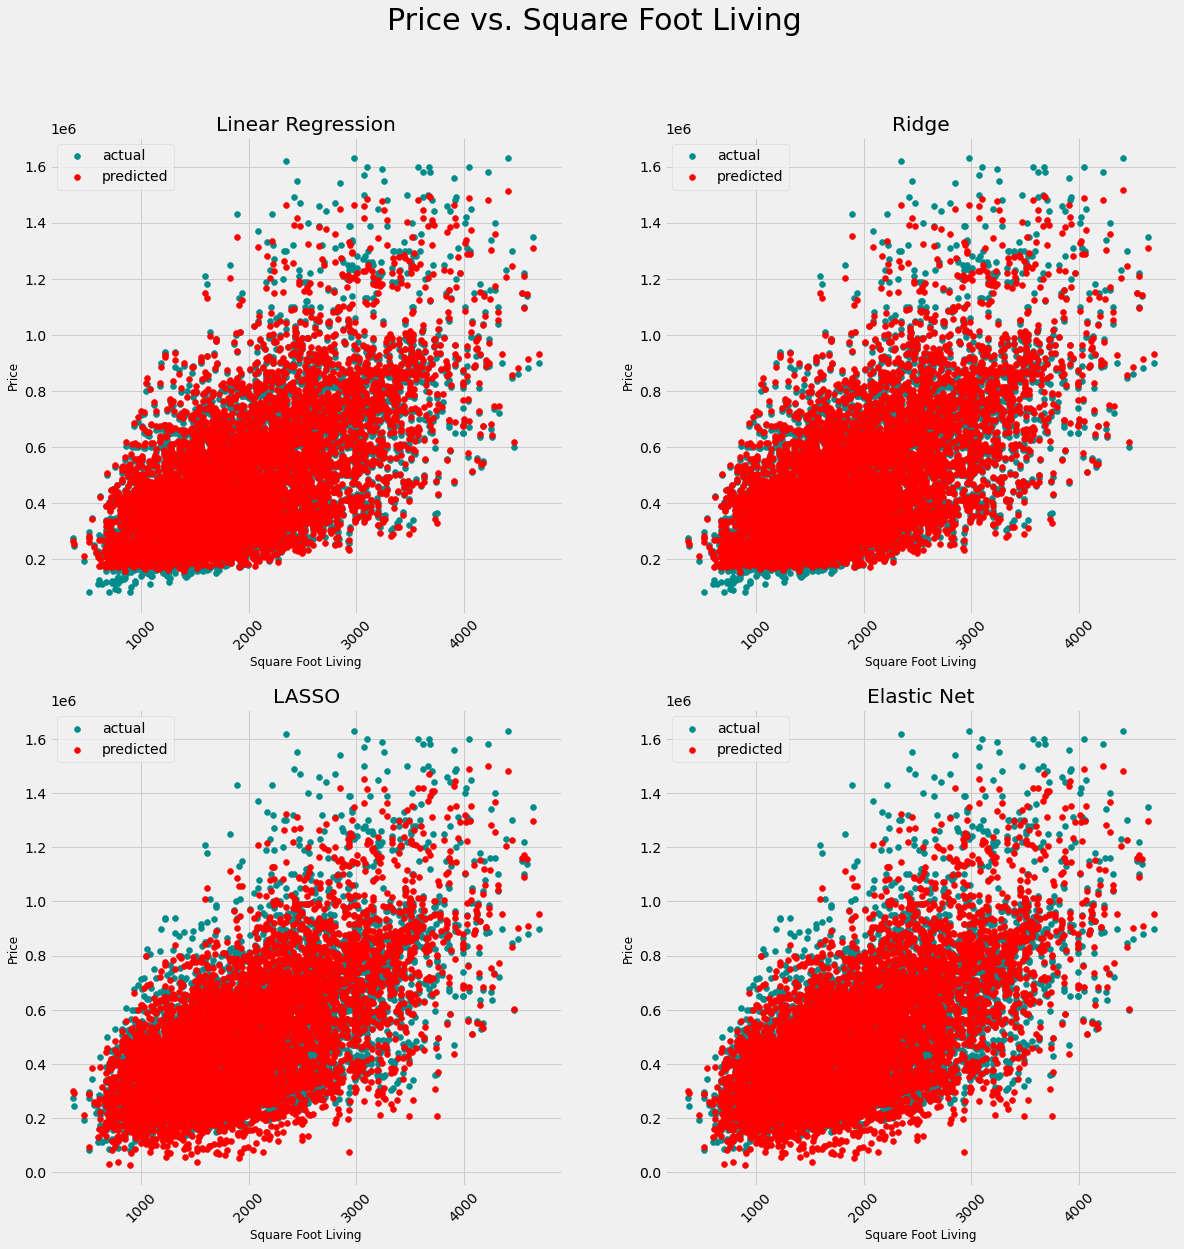

In [94]:
fig = plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_lr, color='red', label='predicted')
plt.title('Linear Regression')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_ridge, color='red', label='predicted')
plt.title('Ridge')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_lasso, color='red', label='predicted')
plt.title('LASSO')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_living'], y_predict_en, color='red', label='predicted')
plt.title('Elastic Net')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.suptitle('Price vs. Square Foot Living', fontsize=30)

plt.show()


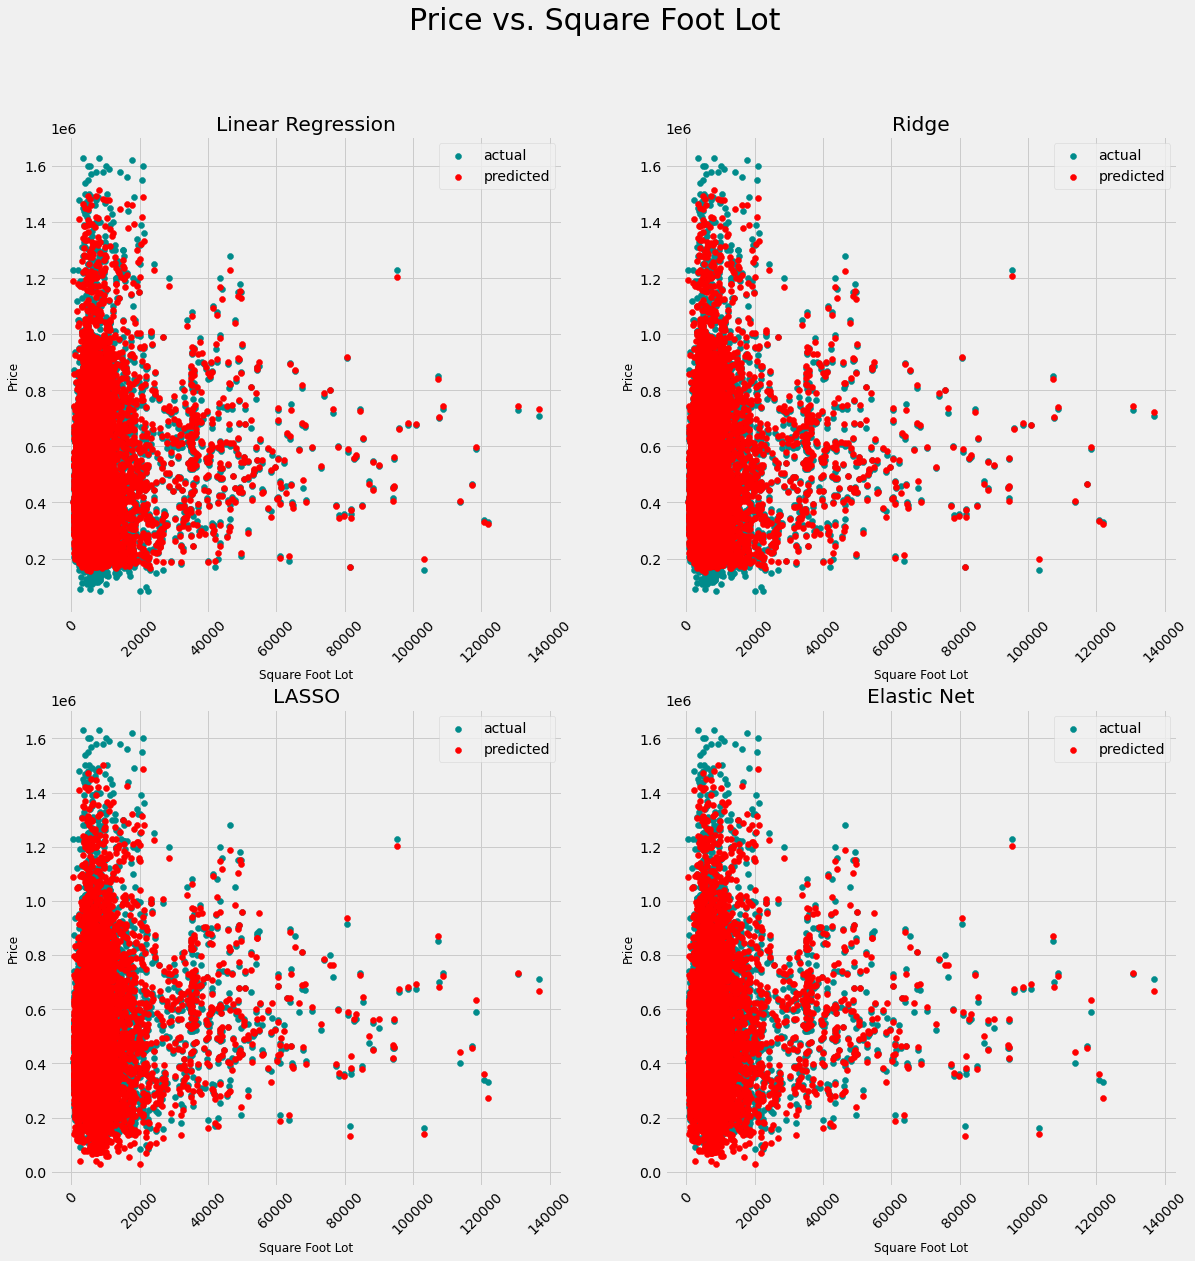

In [95]:
fig = plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_lr, color='red', label='predicted')
plt.title('Linear Regression')
plt.xlabel('Square Foot Lot', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_ridge, color='red', label='predicted')
plt.title('Ridge')
plt.xlabel('Square Foot Lot', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_lasso, color='red', label='predicted')
plt.title('LASSO')
plt.xlabel('Square Foot Lot', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['sqft_lot'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['sqft_lot'], y_predict_en, color='red', label='predicted')
plt.title('Elastic Net')
plt.xlabel('Square Foot Lot', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.suptitle('Price vs. Square Foot Lot', fontsize=30)

plt.show()


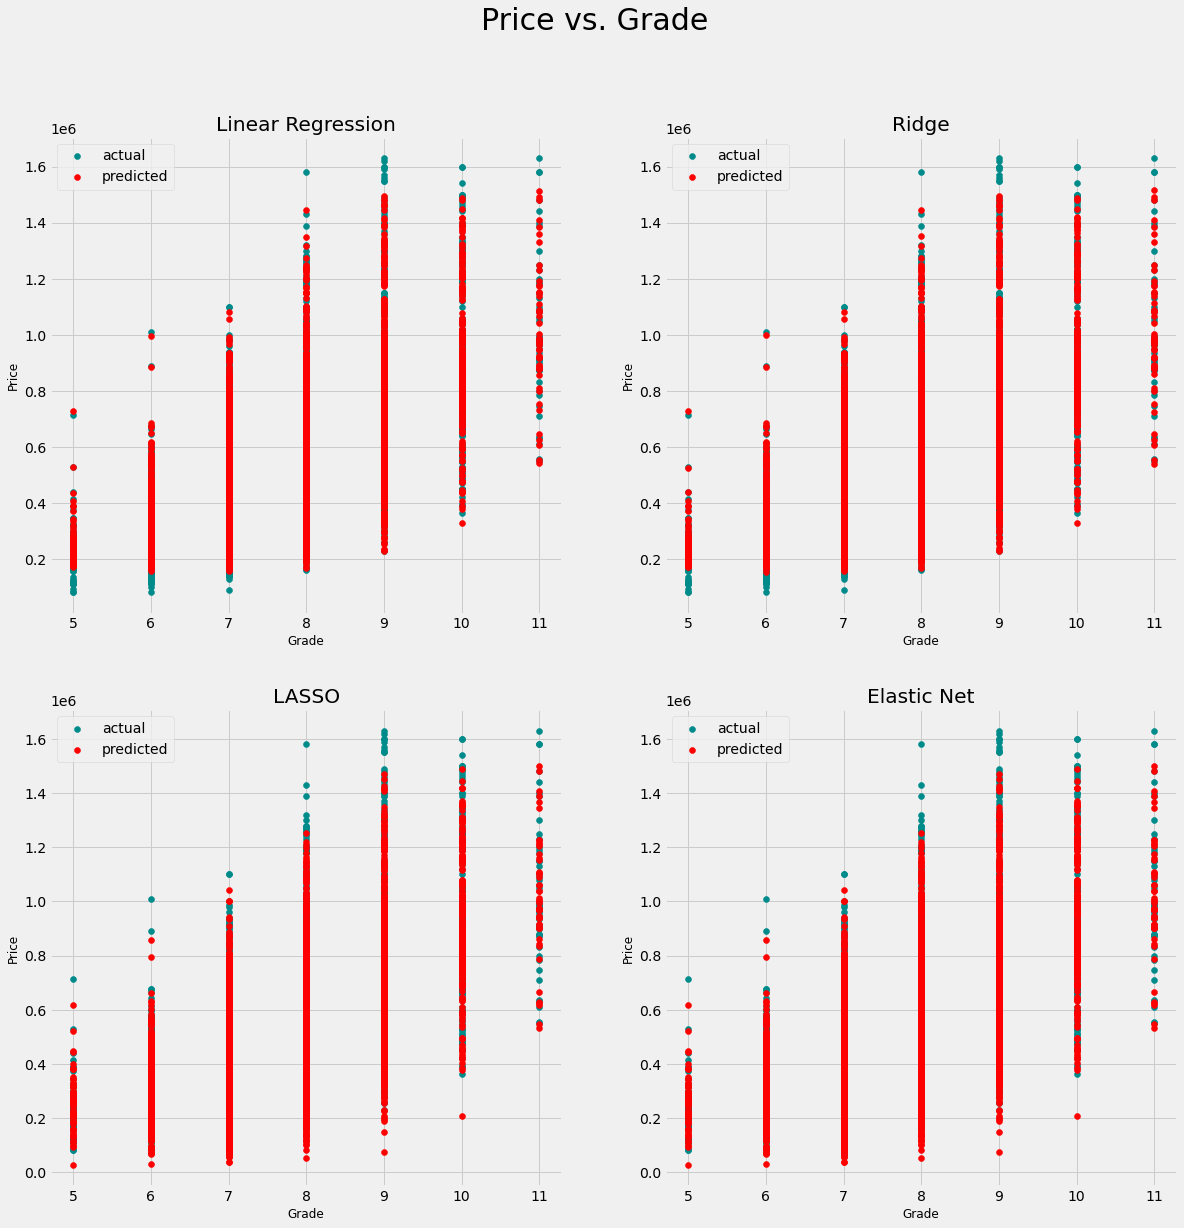

In [96]:
fig = plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_lr, color='red', label='predicted')
plt.title('Linear Regression')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_ridge, color='red', label='predicted')
plt.title('Ridge')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_lasso, color='red', label='predicted')
plt.title('LASSO')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual')
plt.scatter(X_test['grade'], y_predict_en, color='red', label='predicted')
plt.title('Elastic Net')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.suptitle('Price vs. Grade', fontsize=30)

plt.show()